# imports

In [1]:
import sys
sys.path.append('./lib')

import os
import h5py

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/' # Working directory 

import numpy as np
import torch
import pickle
import os
import optuna
from time import time
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import NDNLayer, ConvLayer, STconvLayer, Tlayer, ChannelLayer, IterSTlayer, ReadoutLayer
from NDNT.networks import FFnetwork
from time import time
import dill

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets

# Utilities
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)
print(device)
%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()

class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn_model = ndn_model
        self.LLs = LLs
        self.trial = trial

Running on Computer: [ca1]
Invoking __init__.py for NDNT.utils
Save_dir = /home/dbutts/ColorV1/CLRworkspace/
cuda:1


# load data (all stim)

In [2]:
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
num_lags=16

t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat( datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
100.04785895347595 sec elapsed
167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations


In [3]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valET = UTunits[a]
NCv = len(valET)
print("%d out of %d units used"%(len(valET), len(UTunits)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_corner = matdat['top_corner'][:, 0]

data.set_cells(valET)

174 out of 195 units used
Output set to 174 cells


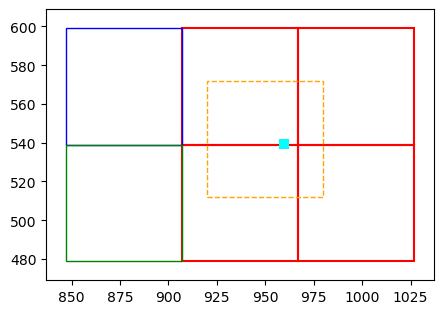

  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [4]:
# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

# Make 60x60 STAs (and GLMs)
Xshift = 14 #8+4 
Yshift = -3 #-10+4
NX = 60

new_tc = np.array([top_corner[0]-Xshift, top_corner[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)

In [29]:
data.dfs_out

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 1.]])

In [5]:
goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))

dirname2 = dirname+'0715/NewGLMs/'
matdat = sio.loadmat(dirname2+'J0715ProcGLMinfo.mat')
LLsNULL = matdat['LLsNULL'][:,0]
LLsGLM = matdat['LLsGLM'][:,0]
LLsGLM2 = matdat['LLsGLM2'][:,0]
drift_terms = matdat['drift_terms']
valET = matdat['cells']
RFcenters = matdat['RFcenters']
#'Gregs': Gopt[:,None], 'XTregs': Xopt
#'top_corner': new_tc[:, None]})
mu0s = utils.pixel2grid(deepcopy(RFcenters[:, [1, 0]]), L=NX)


fw0 = 7
Treg = 0.01
Xreg = 0.000001
Mreg = 0.0001
Creg = None
Dreg = 0.5
Gnet = 0.005
num_iter = 4

68.5% fixations remaining


# define model components

In [ ]:
adam_parsT = utils.create_optimizer_params(
    optimizer_type='AdamW',
    batch_size=4,
    num_workers=0,
    learning_rate=0.01,
    early_stopping_patience=10,  # changed from 4
    optimize_graph=False,
    weight_decay = 0.2)
adam_parsT['device'] = device
adam_parsT['accumulated_grad_batches'] = 6

LGNpars = STconvLayer.layer_dict(
    input_dims = data.stim_dims, num_filters=LGNsubs, bias=False, norm_type=1,
    filter_dims=[1,fw0,fw0,LGNlags] , NLtype='relu', initialize_center=True)
LGNpars['output_norm']='batch'
LGNpars['window']='hamming'
LGNpars['reg_vals'] = {'d2x':Xreg, 'd2t':Treg, 'center': Creg, 'edge_t':100}

proj_pars = ConvLayer.layer_dict(
    num_filters=num_subs, bias=False, norm_type=1, num_inh=num_subs//2,
    filter_dims=proj_width, NLtype='lin', initialize_center=True)
proj_pars['output_norm']='batch'
proj_pars['window']='hamming'

Ilayers = IterSTlayer.layer_dict(
    num_filters=num_subs, bias=False, num_iter=num_iter, output_config='full',
    pos_constraint=True,
    norm_type=1, num_inh=num_subs//2, filter_width=fwI, num_lags=2,
    NLtype='relu', initialize_center=False)
Ilayers['output_norm'] = 'batch'
# Ilayers['reg_vals'] = {'glocal': Gnet}  

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n = 'stim', layer_list=[LGNpars, proj_pars, Ilayers], scaffold_levels=[1,2] )

## 1: READOUT
readout_pars = ReadoutLayer.layer_dict(
    num_filters=NCv, NLtype='lin', bias=False, pos_constraint=True)
readout_pars['gauss_type'] = 'isotropic'
readout_pars['reg_vals'] = {'max': Mreg}

readout_net = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

## 2: DRIFT
drift_pars = NDNLayer.layer_dict(
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg }

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

## 3: COMB 
comb_layer = ChannelLayer.layer_dict(
    num_filters = NCv, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')


## LESS ITERATIONS AND LINEAR PROJECTION LAYER (!)

LGNmods = []
LLsLGN = np.zeros([NCv, 3])
for rep in range(3):
    cnn_iter = NDN.NDN( ffnet_list = [scaffold_net, readout_net, drift_net, comb_net], loss_type='poisson')
    cnn_iter.block_sample = True

    ## Network 1: readout: fixed mus / sigmas
    cnn_iter.networks[1].layers[0].sample = False
    #cnnI1.networks[1].layers[0].mu.data = deepcopy(cnn0x.networks[1].layers[0].mu.data)
    cnn_iter.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn_iter.networks[1].set_parameters(val=False, name='mu')
    cnn_iter.networks[1].set_parameters(val=False, name='sigma')

    ## Network 2: drift: not fit
    cnn_iter.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn_iter.networks[2].set_parameters(val=False)

    ## Network 3: Comb
    cnn_iter.networks[-1].set_parameters(val=False, name='weight')

    cnn_iter.fit( data, **adam_parsT, verbose=2, )
    LLs = cnn_iter.eval_models(data, data_inds=data.val_blks, batch_size=5)
    print(np.mean(LLsNULL-LLs))
    LLsLGN[:, rep] = deepcopy(LLsNULL-LLs)
    LGNmods.append(deepcopy(cnn_iter))

# OPTUNA

In [ ]:
matt_cnns = []

def objective(trial):
    adam_parsT = utils.create_optimizer_params(
        optimizer_type='AdamW',
        batch_size=2, # * 240 timesteps
        num_workers=0,
        learning_rate=trial.suggest_float('learning_rate', 0.001, 0.1),
        early_stopping_patience=4,
        optimize_graph=False,
        weight_decay=trial.suggest_float('weight_decay', 0.01, 1.0))
    adam_parsT['device'] = device
    # how many batches to wait for before calculating the gradient
    adam_parsT['accumulated_grad_batches'] = 6

    LGNpars = STconvLayer.layer_dict(
        input_dims = data.stim_dims, 
        num_filters=4,
        bias=False, 
        norm_type=1,
        filter_dims=[1,  # channels
                     7,  # width
                     7,  # height
                     11], # lags
        NLtype='relu',
        initialize_center=True)
    LGNpars['output_norm']='batch'
    LGNpars['window']='hamming'
    LGNpars['reg_vals'] = {'d2x':Xreg,
                           'd2t':Treg,
                           'center': Creg,
                           'edge_t':100} # just pushes the edge to be sharper
    
    num_subs = trial.suggest_int('num_subs', 10, 50)
    num_inh = trial.suggest_float('num_inh', 0.1, 0.7)
    proj_pars = ConvLayer.layer_dict(
        num_filters=num_subs,
        bias=False,
        norm_type=1,
        num_inh=int(num_inh*num_subs),
        filter_dims=trial.suggest_int('proj_filter_width', 9, 29, step=2),
        NLtype='lin',
        initialize_center=True)
    proj_pars['output_norm']='batch'
    proj_pars['window']='hamming'
    
    iter_layers = IterSTlayer.layer_dict(
        num_filters=num_subs,
        num_inh=int(num_inh*num_subs),
        bias=False,
        num_iter=4,
        output_config='full',
        pos_constraint=True,
        norm_type=1,
        filter_width=trial.suggest_int('iter_filter_width', 5, 17, step=2),
        num_lags=2,
        NLtype='relu',
        initialize_center=False)
    iter_layers['output_norm'] = 'batch'
    #iter_layers['reg_vals'] = {'glocal': 1e-5*trial.suggest_int('iter_glocal', 10, 1e10, log=True)}
    
    scaffold_net =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold',
        xstim_n='stim',
        layer_list=[LGNpars, proj_pars, iter_layers],
        scaffold_levels=[1,2])
    
    ## 1: READOUT
    # reads out from a specific location in the scaffold network
    # this location is specified by the mus
    readout_pars = ReadoutLayer.layer_dict(
        num_filters=NCv,
        NLtype='lin',
        bias=False,
        pos_constraint=True)
    # for defining how to sample from the mu (location) of the receptive field
    readout_pars['gauss_type'] = 'isotropic'
    readout_pars['reg_vals'] = {'max': Mreg}
    
    readout_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[0],
        layer_list = [readout_pars],
        ffnet_type='readout')
    
    ## 2: DRIFT
    drift_pars = NDNLayer.layer_dict(
        input_dims=[1,1,1,NA],
        num_filters=NCv,
        bias=False,
        norm_type=0,
        NLtype='lin')
    drift_pars['reg_vals'] = {'d2t': Dreg}
    
    drift_net = FFnetwork.ffnet_dict(xstim_n = 'Xdrift', layer_list = [drift_pars])
    
    ## 3: COMB 
    comb_layer = ChannelLayer.layer_dict(
        num_filters=NCv,
        NLtype='softplus',
        bias=True)
    comb_layer['weights_initializer'] = 'ones'
    
    comb_net = FFnetwork.ffnet_dict(
        xstim_n = None,
        ffnet_n=[1,2],
        layer_list=[comb_layer],
        ffnet_type='add')

    cnn = NDN.NDN(ffnet_list = [scaffold_net, readout_net, drift_net, comb_net],
                  loss_type='poisson')
    cnn.block_sample = True

    ## Network 1: readout: fixed mus / sigmas
    cnn.networks[1].layers[0].sample = False
    # mus and sigmas are the centers and "widths" of the receptive field center to start at
    cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn.networks[1].set_parameters(val=False, name='mu')
    cnn.networks[1].set_parameters(val=False, name='sigma')

    ## Network 2: drift: not fit
    cnn.networks[2].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
    cnn.networks[2].set_parameters(val=False)

    ## Network 3: Comb
    cnn.networks[-1].set_parameters(val=False, name='weight')

    cnn.fit(data, **adam_parsT, verbose=2)
    LLs = cnn.eval_models(data, data_inds=data.val_blks, batch_size=5)

    cnn_model = Model(cnn, LLsNULL-LLs, study)
    matt_cnns.append(cnn_model)

    with open('models/cnns_01/cnn_'+str(len(study.trials))+'pkl', 'wb') as f:
        pickle.dump(cnn_model, f)

    return LLsNULL-LLs


#study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study = optuna.create_study(direction='maximize')

# enqueue initial parameters
study.enqueue_trial(
    {'learning_rate': 0.01,
     'weight_decay': 0.2,
     'num_subs': 30,
     'num_inh': 0.5,
     'proj_filter_width': 17,
     'iter_filter_width': 7})

study.optimize(objective, n_trials=10)

with open('models/cnns_01/cnn_best.pkl', 'wb') as f:
    pickle.dump(matt_cnns[study.best_trial.number], f)

print(study.best_trial.number, study.best_params)

[I 2023-07-05 18:22:15,856] A new study created in memory with name: no-name-f1e2d16d-e7b7-4e78-a29f-a3d8df716e71


input dims [174, 1, 1, 1]
Model: M174_CsCX_R_N_A

GPU Available: True, GPU Used: True


Epoch 14:  25%|███████████████████████▌                                                                      | 70/279 [00:38<01:53,  1.84it/s, train_loss=0.408]

# analyze models

In [8]:
# load models
cnns = []
for i in range(1, 30):
    with open('models/cnns_02/cnn_'+str(i)+'.pkl', 'rb') as f:
        cnns.append(pickle.load(f))
        
with open('models/cnns_02/study.pkl', 'rb') as f:
    study = pickle.load(f)

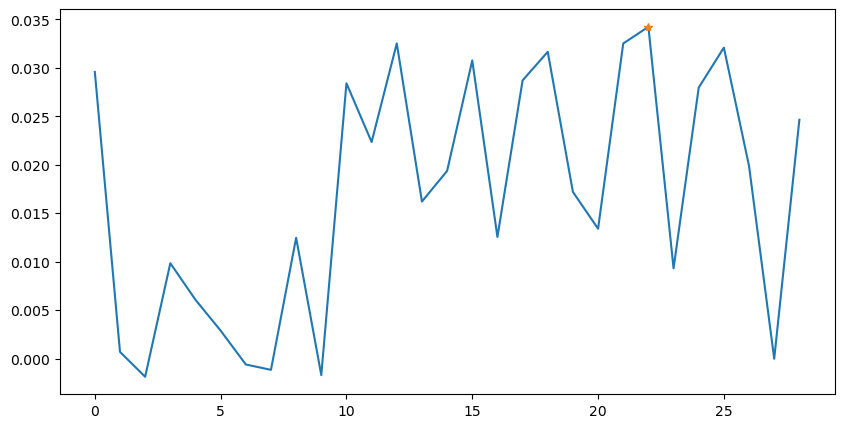

In [9]:
# plot LLs
fig = plt.figure(figsize=(10, 5))
plt.plot([np.mean(cnn.LLs) for cnn in cnns])
# put an asterisk on the best model
plt.plot(study.best_trial.number, np.mean(cnns[study.best_trial.number].LLs), '*')
plt.show()

In [15]:
# print the parameters in the best model
cnns[study.best_trial.number].trial.params

{'learning_rate': 0.0019458712436933295,
 'weight_decay': 0.16992260049675675,
 'num_subs': 29,
 'num_inh': 0.5260602414050571,
 'proj_filter_width': 19,
 'iter_filter_width': 7}